In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

import pymc3 as pm
import pandas as pd
import theano.tensor as tt
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
%matplotlib inline

## 5.1 ロジスティック回帰

### コード 5.1 ロジスティック関数を出力する

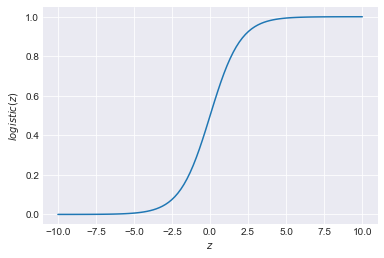

In [4]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$')
plt.ylabel('$logistic(z)$')

In [5]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


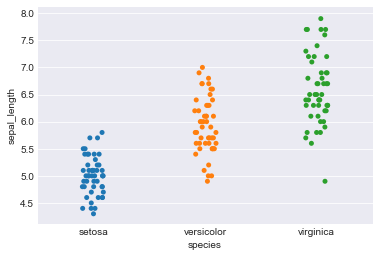

In [8]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

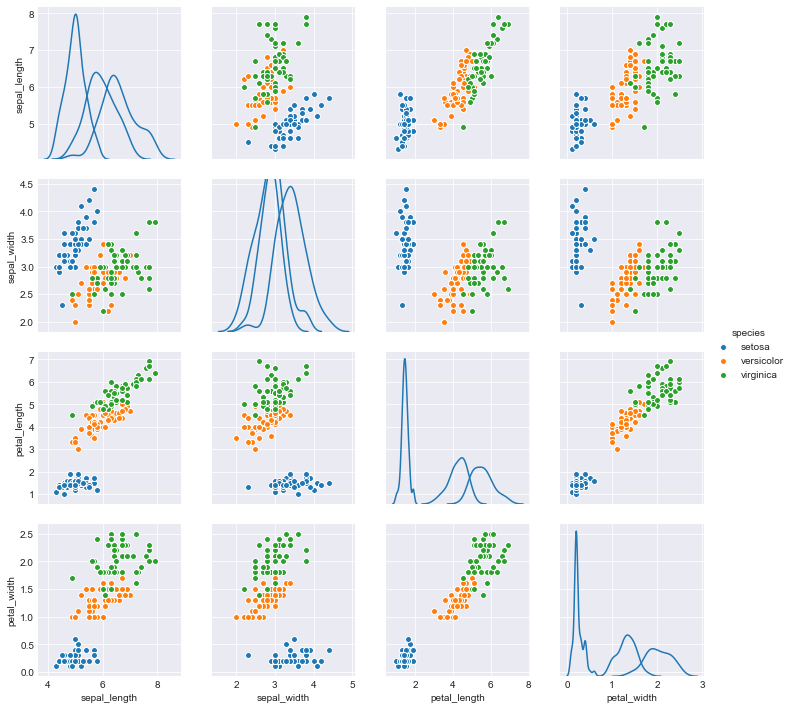

In [9]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### コード5.5 単純ロジスティック回帰モデルのパラメータのKDEとトレースを出力する

In [10]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains:  36%|███▋      | 4011/11000 [00:09<00:16, 417.91draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:27<00:00, 402.73draws/s]
The acceptance probability does not match the target. It is 0.8791032427125421, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120e97f28>,
      dtype=object)

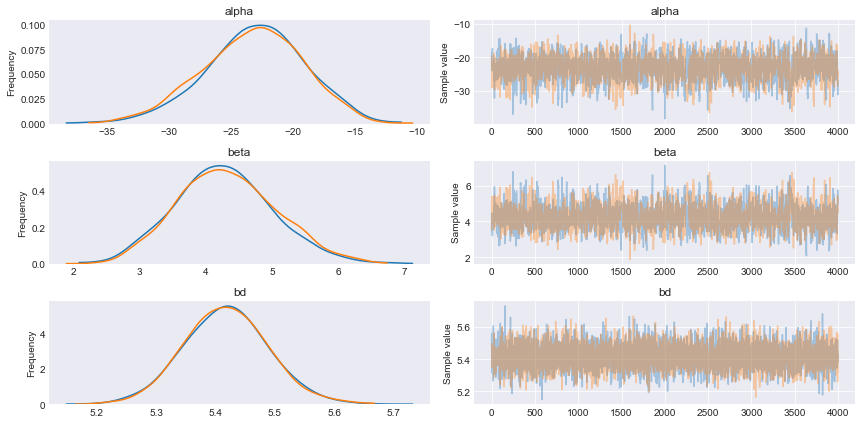

In [11]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1/ (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)
    trace_0 = pm.sample(5000)
    
chain_0 = trace_0[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0, varnames)

In [12]:
pm.summary(chain_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.22,4.00,1.19e-01,-30.62,-15.18,1180.45,1.0
beta,4.29,0.74,2.19e-02,2.78,5.63,1174.61,1.0
bd,5.42,0.07,7.98e-04,5.27,5.55,6561.12,1.0


### コード 5.8 推定されたロジスティック回帰モデルのシグモイド曲線とデータを表示する

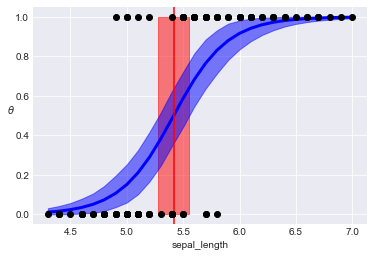

In [13]:
theta = chain_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.axvline(chain_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(chain_0['bd'])
plt.fill_betweenx([0,1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(chain_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:, 0], theta_hpd[:, 1], color='b', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel(r'$\theta$', rotation=0)

## 多重ロジスティック回帰

### コード5.9 多重ロジスティック回帰モデルのパラメータのKDEとトレースをプロットする

In [14]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains:  27%|██▋       | 2925/11000 [00:09<00:28, 283.92draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:39<00:00, 278.20draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1238a9e10>,
      dtype=object)

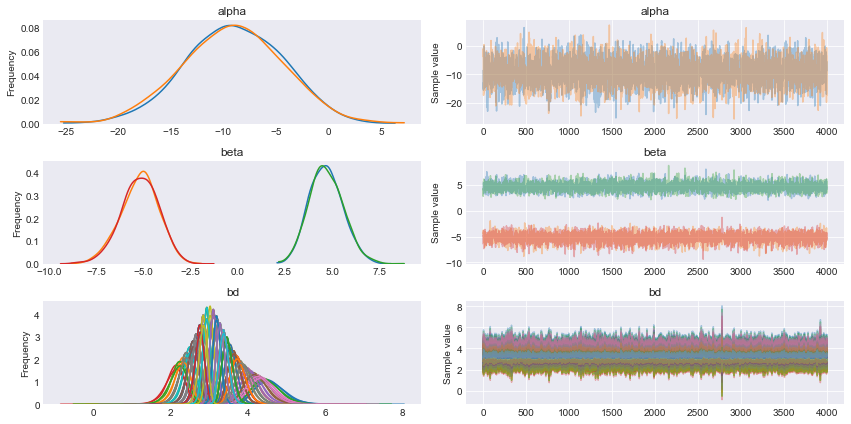

In [15]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    trace_1 = pm.sample(5000)
    
chain_1 = trace_1[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_1, varnames)

### コード5.11 多重ロジスティック回帰モデル：データと境界決定を表示する

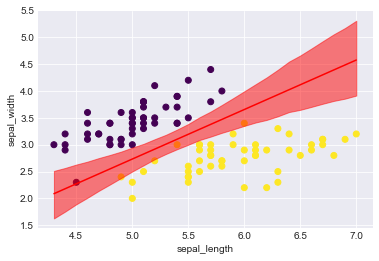

In [16]:
idx = np.argsort(x_1[:, 0])
ld =chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c=y_0, cmap='viridis')
plt.plot(x_1[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=0.5)

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains:  56%|█████▋    | 6215/11000 [00:09<00:06, 759.56draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:17<00:00, 617.62draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123f456a0>,
      dtype=object)

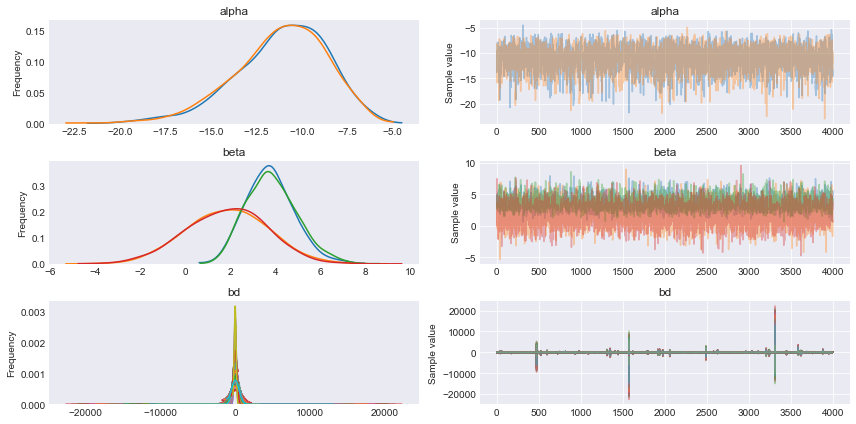

In [19]:
# 相関のある変数の取り扱い
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['petal_length', 'petal_width']
x_1 = df[x_n].values

with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    trace_1 = pm.sample(5000)
    
chain_1 = trace_1[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_1, varnames)

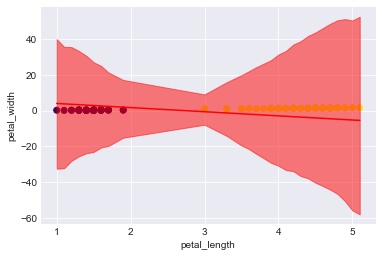

In [20]:
idx = np.argsort(x_1[:, 0])
ld =chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c=y_0, cmap='viridis')
plt.plot(x_1[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=0.5)

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

### コード5.12 多重ロジスティック回帰モデル：独立変数間の相関係数とそのヒートマップを出力する

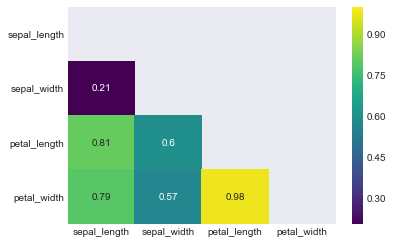

In [21]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

### コード5.13 多重ロジスティック回帰モデル：データがアンバランスな場合の境界を表示する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains:  27%|██▋       | 2916/11000 [00:09<00:23, 339.26draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:37<00:00, 290.23draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8919331772050617, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129a8f898>,
      dtype=object)

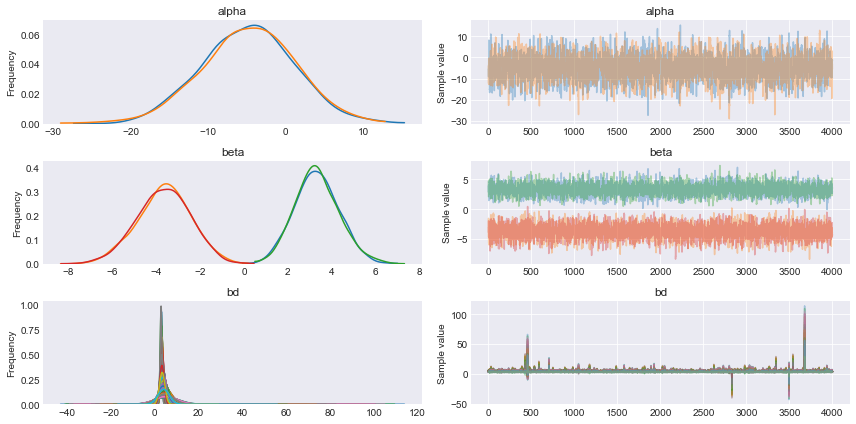

In [27]:
df = iris.query("species == ('setosa', 'versicolor')")
df =df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

with pm.Model() as model_3:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_3, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_3[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y_3)
    trace_3 = pm.sample(5000)
    
chain_3 = trace_3[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_3, varnames)

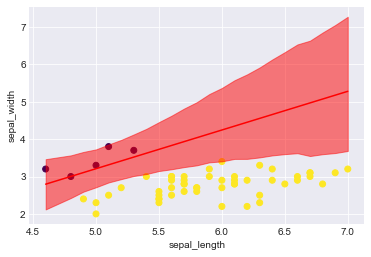

In [29]:
idx = np.argsort(x_3[:, 0])
ld =chain_3['bd'].mean(0)[idx]
plt.scatter(x_3[:, 0], x_3[:, 1], c=y_3, cmap='viridis')
plt.plot(x_3[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain_3['bd'])[idx]
plt.fill_between(x_3[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=0.5)

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains:  30%|██▉       | 3295/11000 [00:09<00:21, 364.97draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:33<00:00, 332.37draws/s]


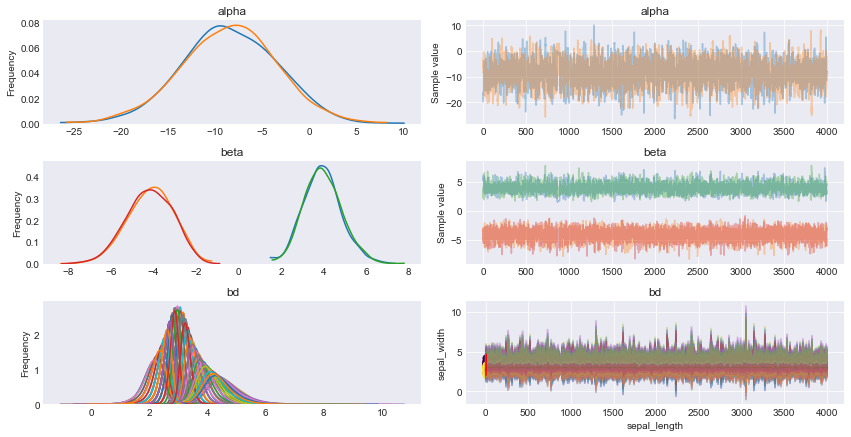

In [30]:
# 演習５
df = iris.query("species == ('setosa', 'versicolor')")
df =df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

with pm.Model() as model_3:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_3, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_3[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y_3)
    trace_3 = pm.sample(5000)
    
chain_3 = trace_3[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_3, varnames)

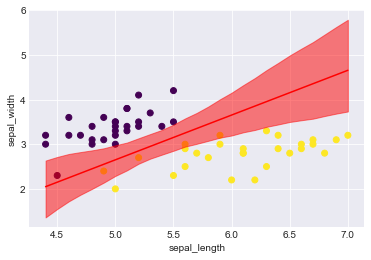

In [31]:
idx = np.argsort(x_3[:, 0])
ld =chain_3['bd'].mean(0)[idx]
plt.scatter(x_3[:, 0], x_3[:, 1], c=y_3, cmap='viridis')
plt.plot(x_3[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain_3['bd'])[idx]
plt.fill_between(x_3[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=0.5)

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

### コード5.15 ソフトマックス回帰モデル：パラメータのKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
 46%|████▌     | 1149/2500 [00:09<00:11, 115.60it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 2500/2500 [00:20<00:00, 119.23it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d90cba8>,
      dtype=object)

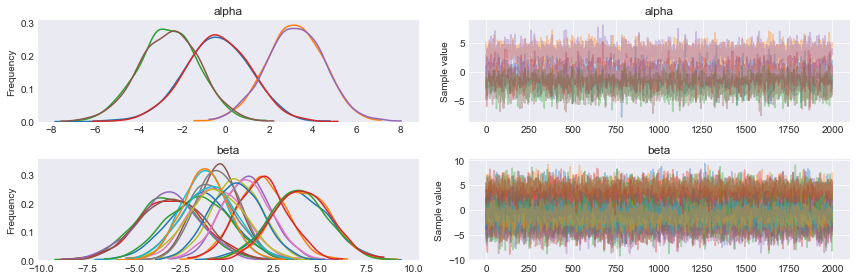

In [33]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4, 3))
    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_s = pm.sample(2000, njobs=1)
    
pm.traceplot(trace_s)

### コード5.17 ソフトマックス回帰モデルでパラメータを固定化した場合のKDEとトレースを出力する

In [34]:
data_pred = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in data_pred:
    y_pred.append(np.exp(point) / np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s)

0.9733333333333334

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
 21%|██        | 1143/5500 [00:09<00:38, 114.40it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 5500/5500 [00:43<00:00, 126.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12edd5b70>,
      dtype=object)

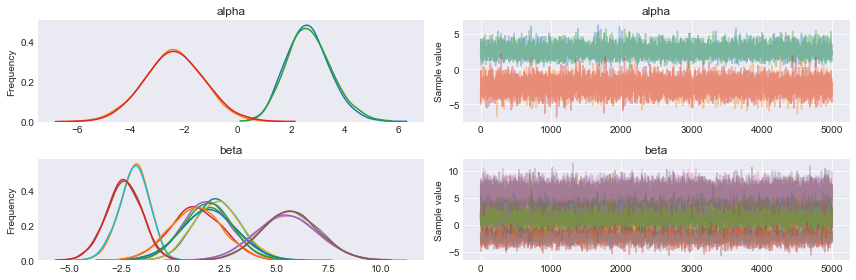

In [35]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4, 2))
    alpha_f = tt.concatenate([[0], alpha])
    beta_f = tt.concatenate([np.zeros((4, 1)), beta], axis=1)
    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_sf = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_sf)

## 5.3 判別モデルと生成モデル

### コード5.19 線形判別分析のパラメータのKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mus]
100%|██████████| 5500/5500 [00:05<00:00, 1023.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ba21400>,
      dtype=object)

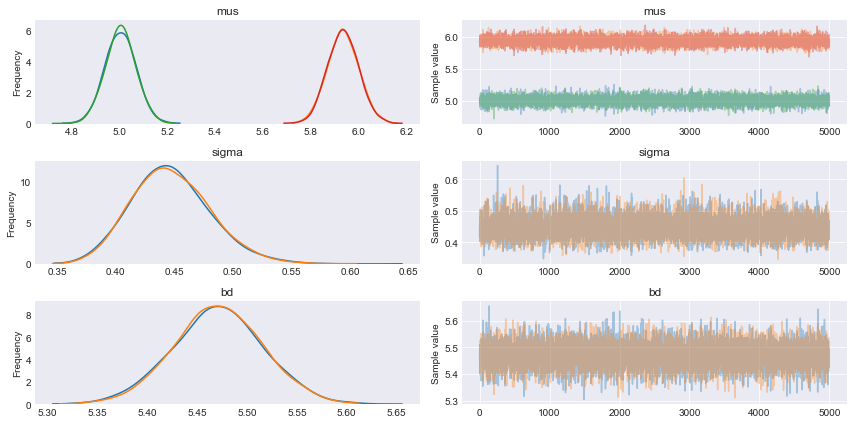

In [36]:
with pm.Model() as model_lda:
    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    trace_lda = pm.sample(5000, njobs=1)
    
pm.traceplot(trace_lda)

### コード5.20 線形判別分析の境界決定と95%HPD区間を表示する

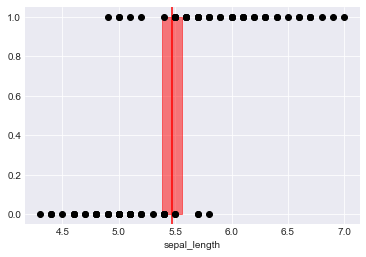

In [37]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)
plt.plot(x_0, y_0, 'o', color='k')
plt.xlabel('sepal_length')

In [38]:
pm.summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,5.01,0.06,5.18e-04,4.89,5.13,13014.27,1.0
mus__1,5.94,0.06,5.05e-04,5.81,6.06,12274.19,1.0
sigma,0.45,0.03,3.44e-04,0.39,0.51,11549.75,1.0
bd,5.47,0.04,3.30e-04,5.38,5.56,12092.88,1.0
